In [19]:
#FOR TESTNG
import os
import random

import numpy as np
import pandas as pd
import PIL

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [2, 2]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from helper import collate_fn, draw_box

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

%load_ext autoreload
%autoreload 2

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

labeled_scene_index = np.arange(106, 134)
image_names

def plot_mask(mask):
    fig, ax = plt.subplots()
    ax.imshow(mask, cmap='binary');

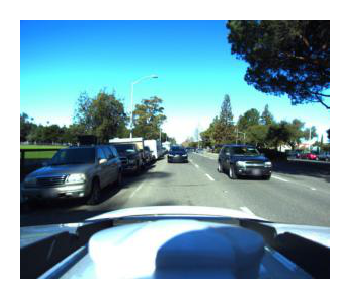

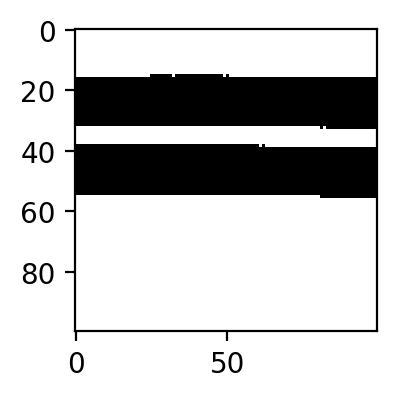

1719


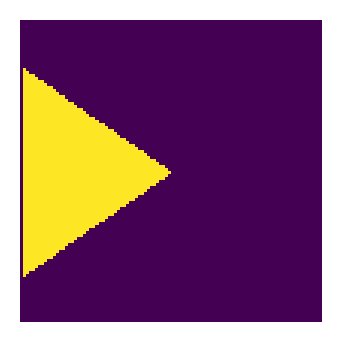

In [4]:
# %load data_helper_triangle.py
# %load data_helper.py
#%%writefile data_helper_triangle_down.py
import os
from PIL import Image

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from helper import convert_map_to_lane_map, convert_map_to_road_map
from helper import collate_fn, draw_box
from shape_splitter import save_masks, get_mask_name


import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [2, 2]
matplotlib.rcParams['figure.dpi'] = 200



NUM_SAMPLE_PER_SCENE = 126
NUM_IMAGE_PER_SAMPLE = 6
image_names = [
    'CAM_FRONT.jpeg',
    'CAM_FRONT_LEFT.jpeg',
    'CAM_BACK_LEFT.jpeg',
    'CAM_BACK.jpeg',
    'CAM_BACK_RIGHT.jpeg',
    'CAM_FRONT_RIGHT.jpeg'
    ]


def plot_mask(mask):
    plt.imshow(mask)
    plt.axis('off');


def load_mask(camera,downsample_shape):
    mask_name = get_mask_name(camera,downsample_shape)
    if os.path.exists(mask_name):
        mask = np.load(mask_name)
    else:
        save_masks(downsample_shape)
        mask = np.load(mask_name)
    mask = mask.reshape(downsample_shape).transpose()
    return mask
    
    
def rebin(a, shape):
    b = a*1.0
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    b = b.reshape(sh).mean(-1).mean(1)
    return b > 0.5
    
    
#BASICALLY YOU JUST HAVE TO SPECIFY THE IMAGE TO LPAD IN THE __GET_ITEM__ on init
# The dataset class for labeled data.
class TriangleLabeledDataset(torch.utils.data.Dataset):    
    def __init__(self, image_folder, annotation_file, scene_index, transform,extra_info=True,camera='CAM_FRONT.jpeg',downsample_shape=(100,100)):
        """
        Args:
            image_folder (string): the location of the image folder
            annotation_file (string): the location of the annotations
            scene_index (list): a list of scene indices for the unlabeled data 
            transform (Transform): The function to process the image
            extra_info (Boolean): whether you want the extra information
        """
        
        assert(camera in image_names)
        self.camera = camera
        self.downsample_shape = downsample_shape
        self.mask = load_mask(camera,downsample_shape)
        self.image_folder = image_folder
        self.annotation_dataframe = pd.read_csv(annotation_file)
        self.scene_index = scene_index
        self.transform = transform
        self.extra_info = extra_info
    
    def __len__(self):
        return self.scene_index.size * NUM_SAMPLE_PER_SCENE

    def __getitem__(self, index):
        scene_id = self.scene_index[index // NUM_SAMPLE_PER_SCENE]
        sample_id = index % NUM_SAMPLE_PER_SCENE
        sample_path = os.path.join(self.image_folder, f'scene_{scene_id}', f'sample_{sample_id}') 
        
        #get camera and only get that image
        image_path = os.path.join(sample_path, self.camera)
        image = Image.open(image_path)
        image = self.transform(image)

        data_entries = self.annotation_dataframe[(self.annotation_dataframe['scene'] == scene_id) & (self.annotation_dataframe['sample'] == sample_id)]
        corners = data_entries[['fl_x', 'fr_x', 'bl_x', 'br_x', 'fl_y', 'fr_y','bl_y', 'br_y']].to_numpy()
        categories = data_entries.category_id.to_numpy()
        
        ego_path = os.path.join(sample_path, 'ego.png')
        ego_image = Image.open(ego_path)
        ego_image = torchvision.transforms.functional.to_tensor(ego_image)
        road_image = convert_map_to_road_map(ego_image)
        road_image_rebinned = rebin(road_image,self.downsample_shape)
        road_image_rebinned_mod = torch.Tensor(road_image_rebinned.numpy()*self.mask)
        road_image_rebinned_mod = road_image_rebinned[self.mask]
        ##Preprocess road image
        #road_image = torch.Tensor(road_image.numpy()*self.mask)
        ## Get resample down
        #road_image_mod = road_image[self.mask]
        
        target = {}
        target['bounding_box'] = torch.as_tensor(corners).view(-1, 2, 4)
        target['category'] = torch.as_tensor(categories)

        if self.extra_info:
            actions = data_entries.action_id.to_numpy()
            # You can change the binary_lane to False to get a lane with 
            lane_image = convert_map_to_lane_map(ego_image, binary_lane=True)
            
            extra = {}
            extra['action'] = torch.as_tensor(actions)
            extra['ego_image'] = ego_image
            extra['lane_image'] = lane_image

            return image, target, road_image_rebinned, extra, road_image_rebinned_mod 
        
        else:
            return image, target, road_image_rebinned 
        

def test_loader(camera='CAM_BACK.jpeg'):
    transform = torchvision.transforms.ToTensor()
    # The labeled dataset can only be retrieved by sample.
    # And all the returned data are tuple of tensors, since bounding boxes may have different size
    # You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
    labeled_trainset = TriangleLabeledDataset(image_folder=image_folder,
                                      annotation_file=annotation_csv,
                                      scene_index=labeled_scene_index,
                                      transform=transform,
                                      extra_info=True,
                                    camera = camera
                                     )
    trainloader = torch.utils.data.DataLoader(labeled_trainset , batch_size=2, \
                                              shuffle=False, num_workers=2, collate_fn=collate_fn)

    sample, target, road_image_rebinned, extra, road_image_rebinned_mod= iter(trainloader).next()
    plt.imshow(sample[0].numpy().transpose(1, 2, 0))
    plt.axis('off');
    fig, ax = plt.subplots()

    ax.imshow(road_image_rebinned[0], cmap='binary');
    plt.show()
    plot_mask(labeled_trainset.mask)
    return sample, target, road_image_rebinned, extra, road_image_rebinned_mod
    
if __name__ == "__main__":   
    image_folder = 'data'
    annotation_csv = 'data/annotation.csv'
    labeled_scene_index = np.arange(106, 134)
    sample, target, road_image_rebinned, extra, road_image_rebinned_mod=test_loader()
    print(len(road_image_rebinned_mod[0]))

In [8]:
road_image_rebinned_mod[0].sum()

tensor(903)

In [1]:
#Load 6 models£
#Load the 100.npy masks
#[FC + Output layer]
#split the inputs by camera
#perform 
'''
road_image_rebinned = rebin(road_image,self.downsample_shape) # downsample the image
road_image_rebinned_mod = torch.Tensor(road_image_rebinned.numpy()*self.mask) # multiplies the images by the mask
road_image_rebinned_mod = road_image_rebinned[self.mask] # selects that part of the images
'''
#your run through each model and stitch it together (when stitching you just take the max), 70 degrees
#upsample the image


'\nroad_image_rebinned = rebin(road_image,self.downsample_shape) # downsample the image\nroad_image_rebinned_mod = torch.Tensor(road_image_rebinned.numpy()*self.mask) \nroad_image_rebinned_mod = road_image_rebinned[self.mask]\n'

In [3]:
import numpy as np

In [9]:
x = np.load("CAM_BACK_LEFT_100.npy")
for i in x:
    print(i)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
F

False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fal

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals